In [1]:
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch import optim
from tqdm import trange, tqdm_notebook
from torch.nn import functional as F
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn import model_selection as ms
from torchvision import datasets, transforms

In [2]:
train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
batch_size = 128
train_data = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_data = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [4]:
dataset = fetch_openml('mnist_784')
x = np.array(dataset['data'])
y = np.array(dataset['target'], dtype='int32')
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.25, random_state=1)

In [5]:
print(type(x_train))

<class 'numpy.ndarray'>


In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 10)
        
    def forward(self, input):
        input = F.relu(self.l1(input))
        input = F.log_softmax(self.l2(input), dim=1)
        return input

In [7]:
EPOCHS = 5
net = Net()
opt = optim.Adam(net.parameters(), lr = 0.001)

for epoch in range(EPOCHS):
    i = 0
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        opt.zero_grad()
        output = net(x)
        #  https://discuss.pytorch.org/t/does-nllloss-handle-log-softmax-and-softmax-in-the-same-way/8835
        loss = F.nll_loss(output, y)
        loss.backward()
        opt.step()
    print(loss)

tensor(0.1916, grad_fn=<NllLossBackward>)
tensor(0.0931, grad_fn=<NllLossBackward>)
tensor(0.0994, grad_fn=<NllLossBackward>)
tensor(0.0915, grad_fn=<NllLossBackward>)
tensor(0.0765, grad_fn=<NllLossBackward>)


In [8]:
layer = net.l1.state_dict()
print(layer['weight'])
print(layer['bias'].shape)

tensor([[-0.0069, -0.0086,  0.0039,  ..., -0.0355, -0.0222,  0.0035],
        [-0.0243,  0.0190,  0.0117,  ...,  0.0134,  0.0002, -0.0080],
        [ 0.0083, -0.0057, -0.0229,  ...,  0.0055,  0.0307, -0.0150],
        ...,
        [ 0.0100,  0.0164,  0.0272,  ..., -0.0355, -0.0053, -0.0243],
        [-0.0320, -0.0094,  0.0176,  ...,  0.0102, -0.0309,  0.0342],
        [ 0.0088,  0.0013,  0.0066,  ..., -0.0189, -0.0195, -0.0291]])
torch.Size([128])


In [9]:
total = 0
correct = 0

with torch.no_grad():
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        output = net(x)
        correct += int(torch.sum(y == torch.argmax(output, axis = 1)))
        total += batch_size

print(f"Accuracy: {correct/total * 100}%")

Accuracy: 97.53620426829268%


In [10]:
outputs = []
with torch.no_grad():
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = torch.Tensor(x_train[low: low + batch_size]).float()
        y = torch.Tensor(y_train[low: low + batch_size]).long()
        output = net(x)
        outputs.extend(list(torch.max(output, 1)[0]))
outputs = np.array(outputs)

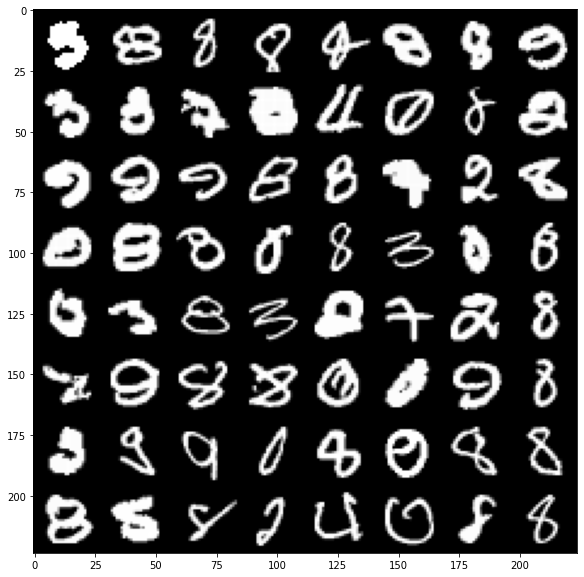

In [11]:
sorted_list = sorted(list(zip(outputs, range(outputs.shape[0]))))
x_bad = x_train[[x[1] for x in sorted_list[:64]]].reshape(8, 28*8, 28)

# let's take a look at the most weird image
plt.figure(figsize=(10, 10))
plt.imshow(np.concatenate(x_bad, axis=1), cmap='gray')

In [12]:
# Useful links
# https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65
# https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
# https://stackoverflow.com/questions/65192475/pytorch-logsoftmax-vs-softmax-for-crossentropyloss

In [13]:
output = None
def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def mse_prime(y_true, y_pred):
    return (2 * (y_pred - y_true)) / y_true.size

def relu(input):
    return np.maximum(input, 0)

def log_softmax(input):
    np.exp(input) - np.log(np.sum(np.exp(input)))

In [ ]:
def init_layer(x, y):
    return np.random.rand(x, y)

l1 = init_layer(28*28, 128)
l2 = init_layer(128, 10)

def forward_backward():
    output = self.bias + np.dot(self.input, self.weights)

In [47]:
class Layer:
    def __init__(self, in_features, out_features, learning_rate=0.001):
        self.in_features = in_features
        self.out_features = out_features
        self.lr = learning_rate
        self.weights = np.random.rand(self.in_features, self.out_features)
        self.bias = np.random.rand(self.out_features)
        
    # forward pass
    def forward(self, input):
        self.input = input
        # x = batch_size
        # input = x * in_features 
        # weights = in_features * out_features
        # bias = out_features
        output = self.bias + np.dot(self.input, self.weights)
        return output
    
    # backward pass
    def backward(self, output_error):
        # x = batch_size
        # dz_dw = self.input = x * in_features
        # dz_db = output_error = x * out_features
        # doutput_dinput/input_error is the error rate WRT to the input = x * in_features
        
        input_error = np.dot(output_error, self.weights.T)
        weights_grad = np.dot(self.input.T, output_error)
#         print('output error')
#         print(output_error[0])
#         print(output_error.shape)
        offset = self.lr * self.weights
#         print('offset')
#         print(offset[0])
#         print('weight grad before')
#         print(self.weights)
        self.weights -= offset
#         print('weight grad after')
#         print(self.weights)
#         print(self.weights.shape)
        output_error = np.mean(output_error, axis=0)
        offset = self.lr * self.bias
        self.bias -= offset
        return input_error

In [40]:
class NeuralNet:
    def __init__(self):
        self.l1 = Layer(784, 128)
        self.l2 = Layer(128, 128)
        self.l3 = Layer(128, 10)
        
    def __call__(self, input):
        return self.forward(input)
        
    def forward(self, input):
        output = relu(self.l1.forward(input))
        output = relu(self.l2.forward(output))
        output = self.l3.forward(output)
        # add log softmax here
        return output
    
    def backward(self, output_error):
        error = self.l3.backward(output_error)
#         print('error')
#         print(error)
        error = self.l2.backward(error)
        self.l1.backward(error)

In [57]:
def encode(y):
    # more pythoninc way to do this?
    output = np.zeros((batch_size, 10))
    for i, x in enumerate(y):
        output[i][x] = 1
    return output
    
EPOCHS = 10
batch_size = 64
nn = NeuralNet()

for epoch in range(EPOCHS):
    i = 0
    loss = 0
    for i in range(y_train.shape[0]//batch_size):
        low = i*batch_size
        x = x_train[low: low + batch_size]
        y = y_train[low: low + batch_size]
        y = encode(y)
        x = x.astype('float32')
        y = y.astype('long')
        output = nn(x)
        # use cross entrorpy loss insteal of mse
        loss = mse(y, output)
        loss_prime = mse_prime(y, output)
        nn.backward(loss_prime)
#         print(nn.l3.weights)
    print(loss)

29152782715165.582
212267437546.15787
1545565190.6361396
11253252.883695077
81894.58969493627
592.3500785724736
4.0560188170317
0.09790161883392116
0.09727242931401983
0.0997208019936416


In [58]:
x_test_1 = x_test[11]
y_test_1 = y_test[11]
output = nn.forward(x_test_1)
print(y_test_1)
print(output)
print(np.argmin(output))
print(np.argmax(output))

2
[0.00182739 0.00191336 0.00159661 0.00189752 0.00175812 0.00175706
 0.00173411 0.00178    0.00144422 0.00159682]
8
1
